# COMP90051 Workshop 7
## Model Design in PyTorch / Convolutional Neural Networks

Last week we worked through the fundamentals of [PyTorch](https://pytorch.org/) and saw the utility of Automatic on-the-fly differentiation ([Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) for gradient-based optimization. In this workshop we will look at methods developed to handle simple computer vision tasks in Pytorch.

## Image Classification on CIFAR-10
Here we will tackle a supervised learning problem on a canonical image dataset, `CIFAR-10`. This consists of $32 \times 32$ 3-channel color images arriving in 10 classes of various animals and vehicles. Lets take a look at some randomly sampled images below, using a handy convenience function from Torch to download and preprocess the data.

In [1]:
import torch
from torch.utils import data

import numpy as np
import time, os

In [2]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

cifar10_transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar10_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar10_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
label_class_map = dict(zip(range(10), classes))

Files already downloaded and verified
Files already downloaded and verified


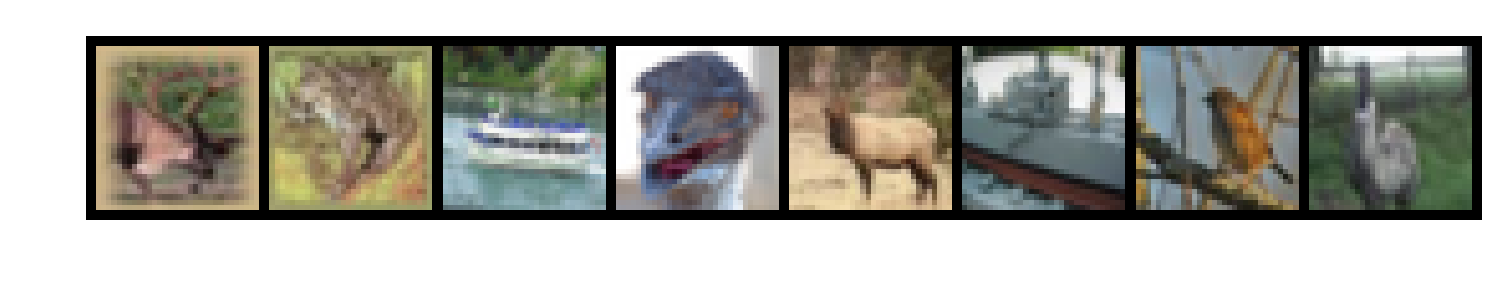

['deer', 'frog', 'ship', 'bird', 'deer', 'ship', 'bird', 'bird']


In [4]:
FIGURE_RESOLUTION = 256
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

def imshow(img, title=None):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.tight_layout()
    
    if title is not None:
        plt.title(str(title))
    plt.show()

images, labels = iter(train_loader).next()
images = images[:8]
labels = labels[:8]

imshow(torchvision.utils.make_grid(images))
print([label_class_map[c.item()] for c in labels])

You should immediately notice that `CIFAR-10` is more substantially more challenging than `MNIST` due to the greater variance within classes. As with last week, we model the conditional class probability given an instance $\mathbf{x}$ through the softmax transformation of the logits $\Phi(\mathbf{x})$, where $\Phi$ represents some possibly nonlinear transformation applied to $\mathbf{x}$. In this case $\Phi$ represents our choice of _network architecture_:
\begin{align}
    p(y=k \vert \mathbf{x}; \mathbf{w}) = \frac{\exp\left[\left(\mathbf{w}_k^T \Phi(\mathbf{x})\right)\right]}{\sum_n \exp\left[\left(\mathbf{w}_n^T \Phi(\mathbf{x})\right)\right]}
\end{align}

The classifier is trained by minimizing the negative log likelihood, which corresponds to the negative cross entropy loss.

\begin{equation}
    \mathcal{L}(\mathbf{w}) = -\log \prod_k p(y=k \vert \mathbf{x}; \mathbf{w}) = -\sum_k y_k \log p\left(y=k \vert \mathbf{x}; \mathbf{w}\right)
\end{equation}

## Model design with `torch.nn.Module`

We'll want to compare a couple of different architectures when attacking this problem. Iterating over different models in the ad-hoc manner we saw last week can quickly get messy. Model design typically (but not always!) decomposes into an _initialization phase_, where the model parameters are defined, and the _forward phase_, where the input tensors $\mathbf{x}$ pass through the Directed Acyclic Graph of operations to produce the model output, the logits $\Phi(\mathbf{x})$. The canonical method of model design in PyTorch reflects this decomposition. We start with inheriting from `torch.nn.Module`, which allows us to access common NN-specific functionality, then:

* Implement the constructor `__init__(self, ...)`. Here we define all network parameters.
* Override the forward method `forward(self, x)`. This accepts the input tensor `x` and returns our desired model output.

Provided your operations are autograd-compliant, the backward pass is implemented automatically as PyTorch walks the computational graph backward. Imagine if you had to manually compute your own parameter gradients - what a time-saver! We'll look at multiple examples of this today, starting with the logistic regression model we investigated last week.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LogisticRegressionModel(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogisticRegressionModel, self).__init__()
        
        # Register weight matrix and bias term as model parameters - automatically tracks operations for gradient computation.
        self.W = torch.nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty([n_features, n_classes])))  # Weights
        self.b = torch.nn.Parameter(torch.zeros([n_classes]))  # Biases
        
    def forward(self, x):
        """
        Forward pass for logistic regression.
        Input: Tensor x of shape [N,C,H,W]
        Output: Logits W @ x + b
        """
        batch_size = x.shape[0]
        
        x = x.view(batch_size, -1)  # Flatten image into vector, retaining batch dimension
        out = torch.matmul(x,self.W) + self.b  # Compute scores
        return out

The parameters added as class attributes are now associated with your module, access them using `Module.parameters()`. Also note the `(...)` operator is redefined to call the `forward` method. You may want to check out the documentation below.

In [6]:
torch.nn.Module?

Init signature: torch.nn.Module()
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.
File:           ~/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py
Type:           type


In [58]:
n_features, n_classes = 32*32*3, 10  # Here we flatten the 3D image into a 1D vector
logistic_regression_model = LogisticRegressionModel(n_features, n_classes)

for p in logistic_regression_model.parameters():
    print(p.shape)

torch.Size([3072, 10])
torch.Size([10])


We'll write a convenient `train` and `test` function that allows us to seamlessly substitute different models - this is essential for fast iteration during development in The Real World. The basic structure is identical to what you encountered last week.

In [59]:
def test(model, criterion, test_loader):
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x, labels = data

        with torch.no_grad():
            logits = model(x)  # Compute scores
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(input=logits, target=labels).item()
            test_preds.append(predictions)
            test_labels.append(labels)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.eq(test_preds, test_labels).float().mean().item()

    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))

def train(model, train_loader, test_loader, optimizer, n_epochs=10):
    """
    Generic training loop for supervised multiclass learning
    """
    LOG_INTERVAL = 250
    running_loss, running_accuracy = list(), list()
    start_time = time.time()
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):  # Loop over training dataset `n_epochs` times

        epoch_loss = 0.

        for i, data in enumerate(train_loader):  # Loop over elements in training set

            x, labels = data

            logits = model(x)

            predictions = torch.argmax(logits, dim=1)
            train_acc = torch.mean(torch.eq(predictions, labels).float()).item()

            loss = criterion(input=logits, target=labels)

            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next iteration


            # ============================================================================
            # You can safely ignore the boilerplate code below - just reports metrics over
            # training and test sets

            running_loss.append(loss.item())
            running_accuracy.append(train_acc)

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:  # Log training stats
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Train accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, train_acc, deltaT))

        print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test(model, criterion, test_loader)
        
    return running_loss, running_accuracy

Load the model parameters into our selected optimizer and we're good to go. We'll include a `momentum` term in the standard SGD update rule to accelerate convergence. Intiutively, this helps the optimizer ignore parameter updates in suboptimal directions, possibly due to noise in the model. 

In [60]:
optimizer = torch.optim.SGD(logistic_regression_model.parameters(), lr=1e-2, momentum=0.9)
lr_loss, lr_acc = train(logistic_regression_model, train_loader, test_loader, optimizer)

[TRAIN] Epoch 0 [0/391]| Mean loss 2.5776 | Train accuracy 0.05469 | Time 0.02 s
[TRAIN] Epoch 0 [250/391]| Mean loss 2.0187 | Train accuracy 0.32812 | Time 9.82 s
Epoch complete! Mean loss: 2.0006
[TEST] Mean loss 1.9499 | Accuracy 0.3315
[TRAIN] Epoch 1 [0/391]| Mean loss 1.8704 | Train accuracy 0.35938 | Time 16.73 s
[TRAIN] Epoch 1 [250/391]| Mean loss 1.8904 | Train accuracy 0.38281 | Time 26.50 s
Epoch complete! Mean loss: 1.8771
[TEST] Mean loss 2.1568 | Accuracy 0.3123
[TRAIN] Epoch 2 [0/391]| Mean loss 2.1652 | Train accuracy 0.24219 | Time 33.43 s
[TRAIN] Epoch 2 [250/391]| Mean loss 1.8474 | Train accuracy 0.32031 | Time 43.02 s
Epoch complete! Mean loss: 1.8471
[TEST] Mean loss 1.7873 | Accuracy 0.3773
[TRAIN] Epoch 3 [0/391]| Mean loss 1.6768 | Train accuracy 0.42188 | Time 50.05 s
[TRAIN] Epoch 3 [250/391]| Mean loss 1.8497 | Train accuracy 0.35938 | Time 59.79 s
Epoch complete! Mean loss: 1.8522
[TEST] Mean loss 2.1148 | Accuracy 0.3285
[TRAIN] Epoch 4 [0/391]| Mean loss

You should be getting a test accuracy just below 40% at the conclusion of training (you may want to try playing around with the optimizer later on to see if you can get better results). While this is significantly better than random chance, this is still a bit of a silly approach because we ignore all spatial structure of the input images. We are also _a priori_ treating all pixels in the image identically, irrespective of their separation/proximity to other pixels. Lets now consider using convolutional networks for the same task.

## Convolutional Networks

Convolutional networks exploit the "translation invariance" property seen in natural images. A representation useful at a certain spatial location is typically useful across the whole image. The convolution operation applies the same linear transformation in different local regions across the image, allowing the model to learn local features depending only on small regions of the image. For a more thorough discussion one may refer to Bishop, Section 5.5.6. We will implement a small convolutional network described below:

1. *Convolutional Layer #1* | 8 5×5 filters with a stride of 1, ReLU activation function.
2. *Max Pooling #1*         | Kernel size 2 with a stride of 1.
3. *Convolutional Layer #2* | 16 5×5 filters with a stride of 1, ReLU activation function.
4. *Max Pooling #2*         | Kernel size 2 with a stride of 1.
5. *Fully Connected Layer #1* | 400 input units (flattened convolutional output), 256 output units.
5. *Fully Connected Layer #2* | 256 input units, 10 output units - yields logits for classification.

In the interests of training time, we keep the number of parameters low by restricting the size of the output channels. Increasing this would most likely increase the classification performance of our network at the expense of additional compute. If you have time you may want to experiment with the architecture. Some questions you may want to consider - is a larger number of parameters always better? How should we adjust the learning rate if we increase the number of parameters?

In [61]:
OUT_C1 = 8
OUT_C2 = 16
DENSE_UNITS = 256

class BasicConvNet(nn.Module):
    def __init__(self, out_c1, out_c2, dense_units, n_classes=10):
        super(BasicConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_c1, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=out_c1, out_channels=out_c2, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, dense_units)
        self.logits = nn.Linear(dense_units, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        out = self.logits(x)
        return out


conv2D_model = BasicConvNet(OUT_C1, OUT_C2, DENSE_UNITS)

The architecture for the default setting is shown below (generated using http://alexlenail.me/NN-SVG/LeNet.html).

<img src="https://i.imgur.com/vNd3Lkg.png" alt="CNN arch" width="1000"/>


**Question (Extension):** Calculate the number of parameters in the logistic regression model and the above convnet. The diagram above may be a useful guide. You may also want to look at the `model.parameters()` method for each `model`.


**Answer:** (Note max-pooling is a parameter-free operation.)
#### Logistic Regression
* Weight matrix: $32 \times 32 \times 3 \times 10$ (Flatten $(3,32,32)$ tensor into vector, 10 output classes).
* Bias term: $10$
* **Total**: $30730$
#### Convolution
* Convolution I: $3 \times 8 \times 5 \times 5 +8$ (3 channels in, 8 channels out, $5 \times 5$ convolutional kernel). 
* Convolution II: $8 \times 16 \times 5 \times 5 + 16$ (8 channels in, 16 channels out, $5 \times 5$ convolutional kernel).
* Dense I: $16 \times 5 \times 5 \times 256 + 256$ (Flatten image and feed to fully connected layer w/ 256 units).
* Dense II: $256 \times 10 + 10$ (10 output classes)
* **Total**: $109050$

We see that the convolutional parameters are relatively lightweight and most of the parameters are attributed to the fully connected layers.

As before, we have to tell the chosen optimizer which parameters to learn, we'll use the same optimizer for the sake of a fair comparison.

In [62]:
optimizer = torch.optim.SGD(conv2D_model.parameters(), lr=1e-2, momentum=0.9)

conv_loss, conv_acc = train(conv2D_model, train_loader, test_loader, optimizer)

[TRAIN] Epoch 0 [0/391]| Mean loss 2.3046 | Train accuracy 0.08594 | Time 0.06 s
[TRAIN] Epoch 0 [250/391]| Mean loss 2.1185 | Train accuracy 0.26562 | Time 17.71 s
Epoch complete! Mean loss: 2.0078
[TEST] Mean loss 1.6779 | Accuracy 0.3947
[TRAIN] Epoch 1 [0/391]| Mean loss 1.7603 | Train accuracy 0.34375 | Time 24.93 s
[TRAIN] Epoch 1 [250/391]| Mean loss 1.6419 | Train accuracy 0.48438 | Time 31.82 s
Epoch complete! Mean loss: 1.6087
[TEST] Mean loss 1.4596 | Accuracy 0.4756
[TRAIN] Epoch 2 [0/391]| Mean loss 1.4067 | Train accuracy 0.46875 | Time 37.49 s
[TRAIN] Epoch 2 [250/391]| Mean loss 1.4459 | Train accuracy 0.46875 | Time 44.48 s
Epoch complete! Mean loss: 1.4300
[TEST] Mean loss 1.3477 | Accuracy 0.5092
[TRAIN] Epoch 3 [0/391]| Mean loss 1.2943 | Train accuracy 0.49219 | Time 50.14 s
[TRAIN] Epoch 3 [250/391]| Mean loss 1.3348 | Train accuracy 0.50781 | Time 57.19 s
Epoch complete! Mean loss: 1.3200
[TEST] Mean loss 1.3025 | Accuracy 0.5356
[TRAIN] Epoch 4 [0/391]| Mean los

You should be seeing a ~25 % increase in test performance just by swapping out the logistic regression architecture for our modest 2D convolutional net! Here the exact convolutional architecture is of secondary importance to our modular approach to model design. Plase ask your tutor if anything is unclear on this front. We'll plot the loss curves below and move on. The downward slope of the loss curve at termination suggests we have not reached full convergence yet.

In [66]:
from scipy.signal import savgol_filter  # Smooth spiky curves
smooth_lr_loss, smooth_conv_loss = savgol_filter(lr_loss, 21, 3), savgol_filter(conv_loss, 21, 3)
smooth_lr_acc, smooth_conv_acc = savgol_filter(lr_acc, 21, 3), savgol_filter(conv_acc, 21, 3)
plt.rcParams['figure.dpi'] = 128

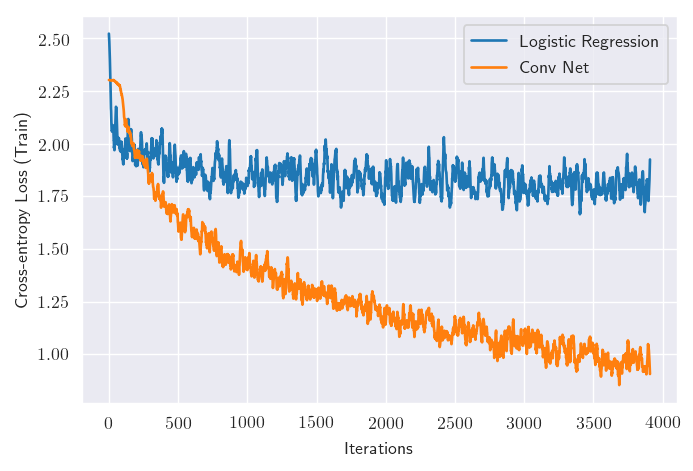

In [67]:
plt.plot(smooth_lr_loss, label='Logistic Regression')
plt.plot(smooth_conv_loss, label='Conv Net')
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss (Train)')
plt.legend()

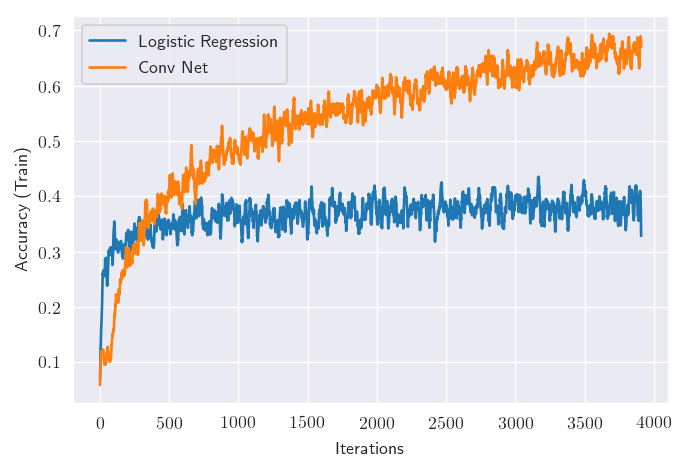

In [69]:
plt.plot(smooth_lr_acc, label='Logistic Regression')
plt.plot(smooth_conv_acc, label='Conv Net')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (Train)')
plt.legend()

# Your turn 🤔: Convolutional Autoencoders
The past two workshops have been fairly passive on your end so far. Here you will get a chance to apply what you have learned over the past fortnight in a relatively advanced application.

## Autoencoders
Recall from lectures that an autoencoder is used to learn an 'efficient' or lower dimensional coding of the input $\mathbf{x} \in \mathbb{R}^n$ to some latent code $\mathbf{z} \in \mathbb{R}^d$. The intuitive idea is that we wish to recover the high-dimensional, potentially sparse data signal represented by $\mathbf{x}$ from some low-dimensional projection $\mathbf{z}$. Natural images are a good example of data which is potentially very high-dimensional (for an $m \times n$ color image, $\mathbf{x} \in \mathbb{R}^{3mn}$ naively, but we would only expect valid inputs to lie in some relatively small subspace of the original space, which can be spanned using fewer 'meaningful' dimensions. By enforcing a lower-dimensional projection, we would like our representation to discard redundant dimensions while retaining dimensions which correspond to intrinsic aspects of the input space. Autoencoding-based models have many applications such as image/speech synthesis, super-resolution and compressed-sensing. 

The autoencoder is trained in an unsupervised manner. It is composed of two components:
* The _encoder_ $f$ from the original space to the latent space, $f(\mathbf{x}) = \mathbf{z}$
* The _decoder_ $g$ from the latent space to the original space, $g(\mathbf{z}) = \mathbf{\hat{x}}$

The autoencoder parameters are learnt such that $g \circ f$ is close to the identity when averaged over the training set. As the latent space is typically much lower dimensional than the original space, the encoder needs to learn a compact representation of the original data that contains sufficient information for the decoder to reconstruct.


The simplest autoencoder model occurs when both the encoder and decoder are linear functions. It is well known (Bourlard and Kamp 1988) that for a linear autoencoder with encoder and decoder functions represented by matrices:
* $Y \in \mathbb{R}^{d \times n}$
* $Y' \in \mathbb{R}^{n \times d}$

respectively, then the quadratic error objective 

$$ \min_{Y, Y'} \sum_k \Vert \mathbf{x}_k - YY'\mathbf{x}_k \Vert^2 $$
is minimized by the PCA decomposition (as you'll see in week 9).

For more general mappings we minimize an empirical estimate of the expected quadratic loss:

$$ \min_{f,g} \sum_k \Vert \mathbf{x}_k - g \circ f(\mathbf{x}_k) \Vert^2 $$

We will use a fully convolutional network for the encoder and a decoder composed of the reciprocal transposed convolution layers (essentially the inverse of the convolution operator - needed to upsample the compressed image).

<img src="https://i.imgur.com/Q69VB3H.png" alt="AE" width="1000"/>

Your task is to define the convolutional encoder we'll be using through `torch.nn.Module`. We'll define the decoder for you, which you can use as a template to build the encoder. Note that it is conventional for the decoder/encoder to mirror one another in terms of the nonlinearities, kernel sizes and strides used at each stage. The basic structure of our architecture is very simple, and you should implement the encoder structure.

* Encoder 
    1. *Convolutional Layer #1* | 8 4×4 filters with a stride of 2, padding 1, ReLU activation function.
    2. *Convolutional Layer #2* | 16 4×4 filters with a stride of 2, padding 1, ReLU activation function.
    3. *Convolutional Layer #3* | 32 4×4 filters with a stride of 2, padding 1 - the output of this layer is the latent code.


* Decoder (mirror encoder structure)
    4. *Transposed Convolution #1* | 32 4×4 filters with a stride of 2, padding 1, ReLU activation function.
    5. *Transposed Convolution #2* | 16 4×4 filters with a stride of 2, padding 1, ReLU activation function.
    6. *Transposed Convolution #3* | 8 4×4 filters with a stride of 2, padding 1, sigmoid activation function.

We apply a sigmoid activation function at the last layer to keep the output within the range $[0,1]$. 

You may find the `torch.nn.Module` reference to be useful here: https://pytorch.org/docs/stable/nn.html. 

In [6]:
OUT_C1 = 8
OUT_C2 = 16
OUT_C3 = 32
OUT_C4 = 32
EMBEDDING_DIMENSION = 32

class ConvEncoder(nn.Module):
    def __init__(self, out_c1, out_c2, out_c3, out_c4, embedding_dim):
        super(ConvEncoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_c1, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_c1, out_channels=out_c2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=out_c2, out_channels=embedding_dim, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        out = self.conv3(x)

        return out
    
class ConvDecoder(nn.Module):
    def __init__(self, out_c1, out_c2, out_c3, out_c4, embedding_dim):
        super(ConvDecoder, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=embedding_dim, out_channels=out_c2, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=out_c2, out_channels=out_c1, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels=out_c1, out_channels=3, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        out = torch.sigmoid(self.deconv3(x))

        return out

Note that we could have defined a single `Autoencoder(nn.Module)` subclass with `encode(...)` and `decode(...)` defined as distinct methods as well. Since we're considering an unsupervised setup the training loop is slightly different. Training is conducted using the above quadratic loss.

In [7]:
def train_autoencoder(encoder, decoder, train_loader, test_loader, optimizer, n_epochs=10, cuda=False):
    """
    Generic training loop for supervised multiclass learning
    """
    LOG_INTERVAL = 250
    running_loss = list()
    start_time = time.time()
    # criterion = torch.nn.BCELoss(reduction="sum")
    criterion = torch.nn.MSELoss(reduction="sum")

    for epoch in range(n_epochs):  # Loop over training dataset `n_epochs` times

        epoch_loss = 0.

        for i, data in enumerate(train_loader):  # Loop over elements in training set
            
            x, _ = data
            batch_size = x.shape[0]
            
            if cuda is True:  # Send to GPU
                x = x.to(device)

            code = encoder(x)
            reconstructed_x = decoder(code)

            loss = criterion(input=reconstructed_x, target=x) / batch_size

            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next iteration


            # ============================================================================
            # You can safely ignore the boilerplate code below - just reports metrics over
            # training and test sets

            running_loss.append(loss.item())

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:  # Log training stats
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, deltaT))

        print('Epoch complete! Mean training loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test_loss = 0.
        
        for i, data in enumerate(test_loader):
            x, _ = data

            if cuda is True:  # Send to GPU
                x = x.to(device)
            
            with torch.no_grad():
                code = encoder(x)
                reconstructed_x = decoder(code)

                test_loss += criterion(input=reconstructed_x, target=x).item() / batch_size

        print('[TEST] Mean loss {:.4f}'.format(test_loss/len(test_loader)))

First we initialize the encoder and decoder modules. We pass the parameter lists of both modules to our optimizer. Since `model.parameters()` returns a generator we'll `chain` both generators together. We'll use the same SGD w/ momentum optimizer, except add Nesterov momentum to stabilize training and accelerate convergence.

In [31]:
use_cuda = True  # Set this to true if using a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = ConvEncoder(OUT_C1, OUT_C2, OUT_C3, OUT_C4, EMBEDDING_DIMENSION)
decoder = ConvDecoder(OUT_C1, OUT_C2, OUT_C3, OUT_C4, EMBEDDING_DIMENSION)

if use_cuda is True:
    encoder.to(device)
    decoder.to(device)

In [32]:
from itertools import chain
# optimizer = torch.optim.SGD(chain(encoder.parameters(), decoder.parameters()), lr=1e-3, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=1e-3)

train_autoencoder(encoder, decoder, train_loader, test_loader, optimizer, cuda=use_cuda, n_epochs=48)

[TRAIN] Epoch 0 [0/391]| Mean loss 206.8095 | Time 0.03 s
[TRAIN] Epoch 0 [250/391]| Mean loss 87.0965 | Time 5.26 s
Epoch complete! Mean training loss: 72.2663
[TEST] Mean loss 66.4987
[TRAIN] Epoch 1 [0/391]| Mean loss 42.5123 | Time 9.65 s
[TRAIN] Epoch 1 [250/391]| Mean loss 36.1107 | Time 14.87 s
Epoch complete! Mean training loss: 34.3089
[TEST] Mean loss 46.7299
[TRAIN] Epoch 2 [0/391]| Mean loss 31.5931 | Time 19.24 s
[TRAIN] Epoch 2 [250/391]| Mean loss 28.2346 | Time 24.45 s
Epoch complete! Mean training loss: 27.5036
[TEST] Mean loss 40.5781
[TRAIN] Epoch 3 [0/391]| Mean loss 25.9376 | Time 28.79 s
[TRAIN] Epoch 3 [250/391]| Mean loss 24.8217 | Time 33.94 s
Epoch complete! Mean training loss: 24.2063
[TEST] Mean loss 36.2661
[TRAIN] Epoch 4 [0/391]| Mean loss 24.6368 | Time 38.28 s
[TRAIN] Epoch 4 [250/391]| Mean loss 21.8988 | Time 43.43 s
Epoch complete! Mean training loss: 21.5560
[TEST] Mean loss 32.3431
[TRAIN] Epoch 5 [0/391]| Mean loss 19.1399 | Time 47.79 s
[TRAIN] E

Below we'll grab 8 random images from the test set and plot the images along with their reconstructions.

In [12]:
plt.rcParams['figure.dpi'] = 256
test_im_generator = iter(test_loader)

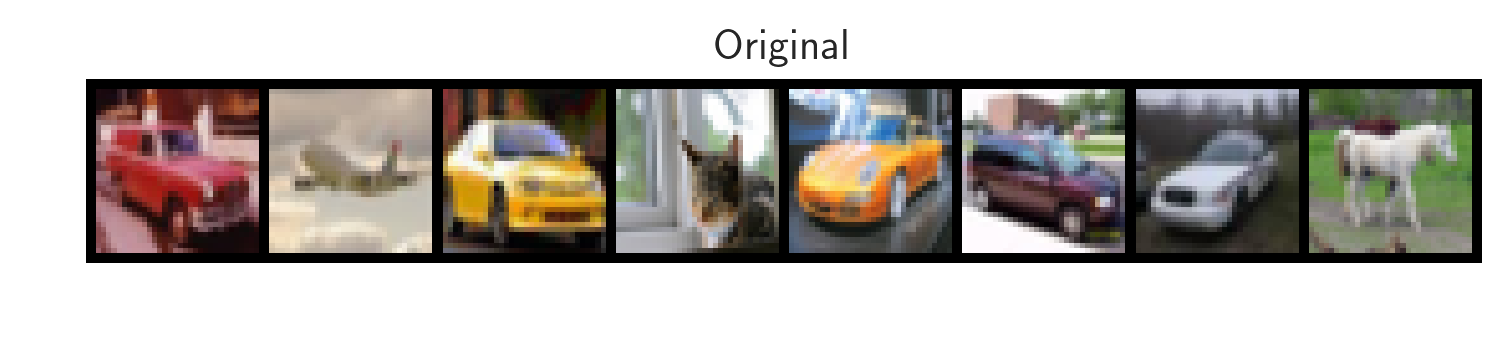

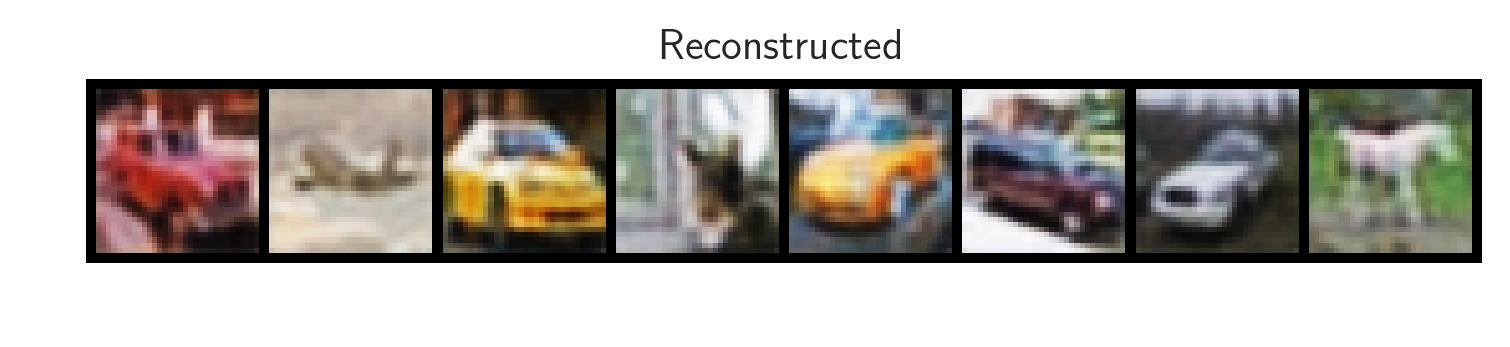

['car', 'plane', 'car', 'cat', 'car', 'car', 'car', 'horse']


In [33]:
images, labels = test_im_generator.next()
images = images[:8]
labels = labels[:8]

with torch.no_grad():
    code = encoder(images.to(device))
    reconstructed_images = decoder(code)

imshow(torchvision.utils.make_grid(images), title='Original')
imshow(torchvision.utils.make_grid(reconstructed_images), title='Reconstructed')
print([label_class_map[c.item()] for c in labels])

Not bad! Looks like we were able to recover most of the salient features from our lower dimensional projection. The reconstructed images are somewhat recognizable as their original classes. You may want to try adjusting the architecture / adding layers, or changing the latent code dimension to see the effect on the reconstruction loss.

## Extension: Interpolations
A popular application of autoencoder models is the generation of a semantically meaningful latent space. To test if our autoencoder has learnt a well-structured latent space, one can decode a convex combination of the latent codes for datapoints, $\mathbf{x}$ and $\mathbf{x}'$. If interpolating between two points in latent space produces a meaningful image in data space that is not a pixelwise admixture of $\mathbf{x}$ and $\mathbf{x'}$, this suggests that nearby points in latent space are semanatically similar - i.e. the different classes are clustered together in latent space. This property of an 'interpretable' latent space may be a useful representation for downstream tasks.

Concretely, we achieve this by interpolating the samples $x$ and $x'$ along a line in latent space.

$$ I(x, x'; \alpha) = g\left((1-\alpha) f\left(x\right) + \alpha f(x')\right)$$

<img src="https://i.imgur.com/QgCkUTa.png" alt="AE_int" width="750"/>

In [24]:
# Choose images to interpolate between, add batch dimension
x_i, x_f = torch.unsqueeze(images[0], dim=0), torch.unsqueeze(images[3], dim=0)
encoder.to('cpu');
decoder.to('cpu');

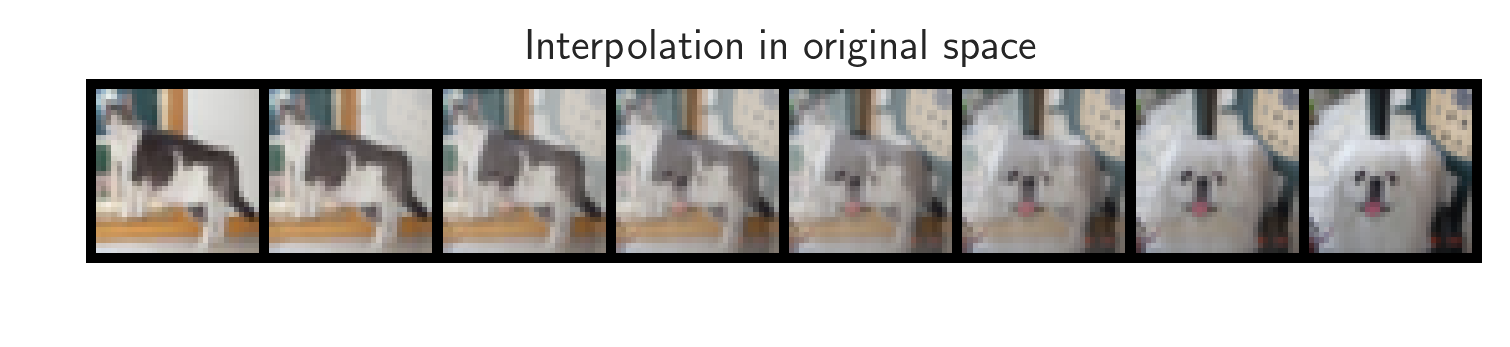

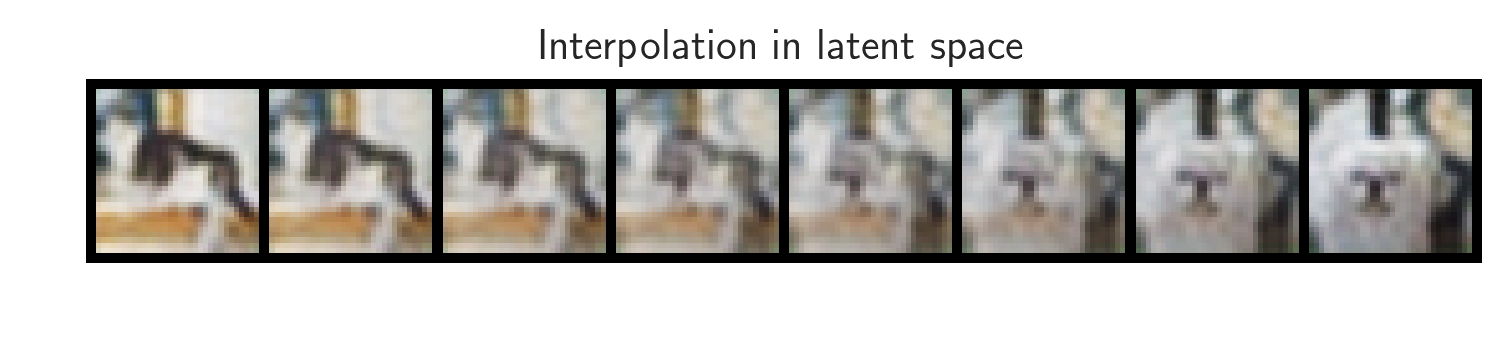

In [146]:
interpolations = list()
latent_interpolations = list()
line = torch.linspace(0,1,steps=8)

# Get latent representations of images
with torch.no_grad():
    code_i = encoder(x_i)
    code_f = encoder(x_f)

for alpha in line:
    
    # Interpolate along line in data space
    x_interpolated = alpha * x_f + (1-alpha) * x_i
    
    with torch.no_grad():
        # Interpolate along line in latent space
        reconstruction = decoder(alpha * code_f + (1-alpha) * code_i)
    
    interpolations.append(x_interpolated)
    latent_interpolations.append(reconstruction)

interpolations = torch.cat(interpolations)
latent_interpolations = torch.cat(latent_interpolations)

imshow(torchvision.utils.make_grid(interpolations), title='Interpolation in original space')
imshow(torchvision.utils.make_grid(latent_interpolations), title='Interpolation in latent space')

You should find that interpolations in the latent space tends to be more structured than interpolation in the original pixel space - in the sense that it is more than just pixelwise interpolation. Each reconstructed image should resemble one class instead of an admixture of two classes. Conventional autoencoders aren't strictly the best task for this because they don't enforce any structure on the latent space. The [variational autoencoder](http://paulrubenstein.co.uk/variational-autoencoders-are-not-autoencoders/) explicitly enforces some sort of user-specified structure on the latent space and typically leads to superior latent space representations. It is one of the most prominent marriages of deep learning with traditional Bayesian methods. But this is out of the scope of the subject and we're out of time - that's all for this week!